# Inverse Dynamics in Mujoco

## Introduction

This tutorial shows you how to use MuJoCo to compute the required torques to achieve a given directory. The example compares the computed torque from two different integrators.

If you have a model, inverse dynamics are a great way to compute *most* of the torques required to make your robot move along a particular trajectory. What we see from this example, though, is that if there is error -- due to a poorly-selected integrator or too large of a time step -- the computed torque does not capture the actual, underlying dynamics. This can have big implications if you want to control your robot with a feed-forward term that has noise, latency, etc.

In [1]:
import os
import mujoco
import numpy
import mediapy as media
import matplotlib.pyplot as plt
import math
import yaml
import scipy.interpolate
width = 800
height = 600

We create an xml template in python and then format it.  We replace the ```ts``` variable with .001 initially
it keeps the xml in the script so there are not extra files floating around.

In [2]:
xml_template = """
<mujoco>
  <option timestep="{ts:e}"/>
  <option integrator="{integrator}"/>
  <visual><global offwidth="800" offheight="600" /></visual>    
    <worldbody>
        <light name="top" pos="0 0 1"/>
        <body name="A" pos="0 0 0">
            <joint name="j1" type="hinge" axis="0 1 0" pos="0 0 0"/>
            <geom type="box" size=".5 .05 .05" pos=".5 0 0" rgba="1 0 0 1" mass="1"/>
            <body name="B" pos="1 0 0">
                <joint name="j2" type="hinge" axis="0 1 0" pos="0 0 0"/>
                <geom type="box" size=".5 .05 .05" pos=".5 0 0" rgba="1 0 0 1" mass="1"/>
            </body>
        </body>
    </worldbody>
    <actuator>
        <general name="m1" joint="j1"/>
        <general name="m2" joint="j2"/>
    </actuator>

</mujoco>
"""
xml = xml_template.format(ts=1e-3,integrator='RK4')

We load our model, data, and renderer from the xml

In [3]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model,width=width, height=height)


I create a simple controller that adds torque to the two joints using a sinusoidal curve.

In [4]:
freq = 1
def my_controller(model, data):
    theta1 = math.sin(2*math.pi*(freq*data.time))
    theta2 = math.sin(2*math.pi*(freq*data.time-.25))
    data.ctrl = [theta1,theta2]
    return

We run the simulation in order to obtain the system's state as a function of time.

In [5]:
mujoco.mj_resetData(model,data)

duration = 3
framerate =30

q = []
w = []
a = []
t = []
xy = []
frames = []

try:
    mujoco.set_mjcb_control(my_controller)
    while data.time<duration:

        mujoco.mj_step(model,data)

        q.append(data.qpos.copy())
        w.append(data.qvel.copy())
        a.append(data.qacc.copy())
        xy.append(data.xpos.copy())
        t.append(data.time)
        
        if len(frames)<data.time*framerate:
        
            renderer.update_scene(data)
            # renderer.update_scene(data,"world")
            pixels = renderer.render()
            frames.append(pixels)
finally:
    mujoco.set_mjcb_control(None)
        
media.show_video(frames, fps=framerate,width=width, height=height)
# media.write_video('pendulum.mp4',frames,fps=framerate)

Convert the obtained values into arrays

In [7]:
q = numpy.array(q)
w = numpy.array(w)
a = numpy.array(a)
xy = numpy.array(xy)
t = numpy.array(t)

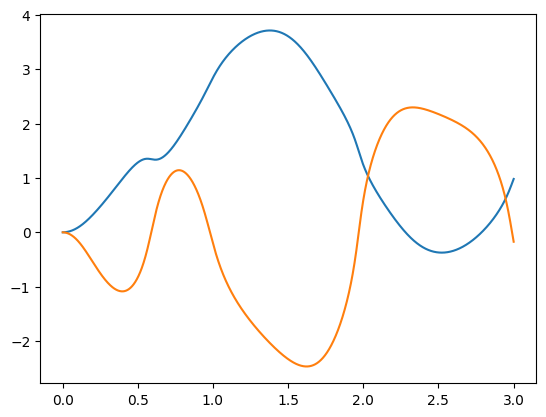

In [8]:
plt.plot(t,q)

Reset the model to the same starting condition and substitute each position, velocity, and acceleration term into the state for each time, and use the ```data.qfrc_inverse``` function to evaluate the required joint torques...then append these to a list

In [9]:
mujoco.mj_resetData(model,data)
torque_est = []

for q_ii,w_ii,a_ii in zip(q,w,a):
    data.qpos[:] = q_ii
    data.qvel[:] = w_ii
    data.qacc[:] = a_ii
    mujoco.mj_inverse(model,data)
    torque =  data.qfrc_inverse.copy()
    torque_est.append(torque)

torque_est = numpy.array(torque_est)

Plot the resulting torques.

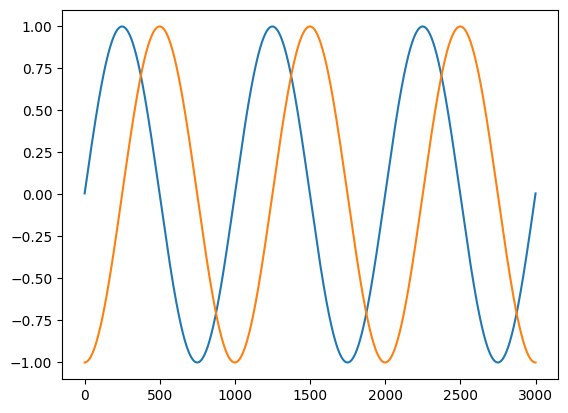

In [10]:
plt.plot(torque_est)

This works great for data at 1000 Hz, but what if our simulation had been run at a slower speed or with a different integrator? First we create a function that runs the sim with different parameters

In [11]:
def run_model(controller,**kwargs):
    xml = xml_template.format(**kwargs)
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    mujoco.mj_resetData(model,data)
    
    duration = 3
    framerate =30
    
    q2 = []
    w2 = []
    a2 = []
    t2 = []
    xy2 = []
    
    try:
        mujoco.set_mjcb_control(controller)
        while data.time<duration:
    
            mujoco.mj_step(model,data)
    
            q2.append(data.qpos.copy())
            w2.append(data.qvel.copy())
            a2.append(data.qacc.copy())
            xy2.append(data.xpos.copy())
            t2.append(data.time)
    finally:
        mujoco.set_mjcb_control(None)
    
    q2 = numpy.array(q2)
    w2 = numpy.array(w2)
    a2 = numpy.array(a2)
    xy2 = numpy.array(xy2)
    t2 = numpy.array(t2)
    return model,data,q2,w2,a2,xy2,t2

Now we run with a different integrator

In [12]:
model,data,q2,w2,a2,xy2,t2 = run_model(my_controller,ts=1e-3,integrator='Euler')

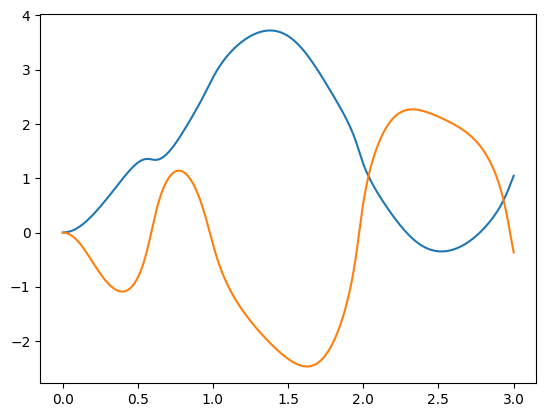

In [13]:
plt.plot(t2,q2)

Though the motion looks nearly the same as before, there are small differences, and they grow with time:

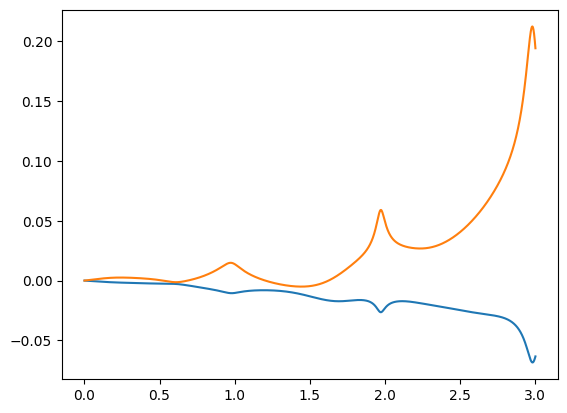

In [14]:
y=plt.plot(t,q-q2)

The inverse dynamics begin look worse too:

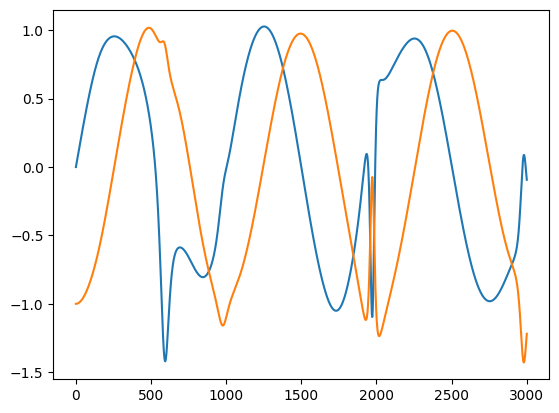

In [15]:
def calc_torque(model,data,q2,w2,a2):
    torque_est2 = []
    
    for q_ii,w_ii,a_ii in zip(q2,w2,a2):
        data.qpos[:] = q_ii
        data.qvel[:] = w_ii
        data.qacc[:] = a_ii
        mujoco.mj_inverse(model,data)
        torque =  data.qfrc_inverse.copy()
        torque_est2.append(torque)
    
    torque_est2 = numpy.array(torque_est2)
    return torque_est2

torque_est2 = calc_torque(model,data,q2,w2,a2)
plt.plot(torque_est2)

And when applied back to the original model, there is quite a difference.  First we create an interpolation function, and use that to supply a torque command at a time t

In [16]:
f = scipy.interpolate.interp1d(t2,torque_est2.T,fill_value=(t2[0],t2[-1]), bounds_error=False,)

def my_controller2(model, data):
    torque = f(data.time)
    data.ctrl = [*torque]
    return

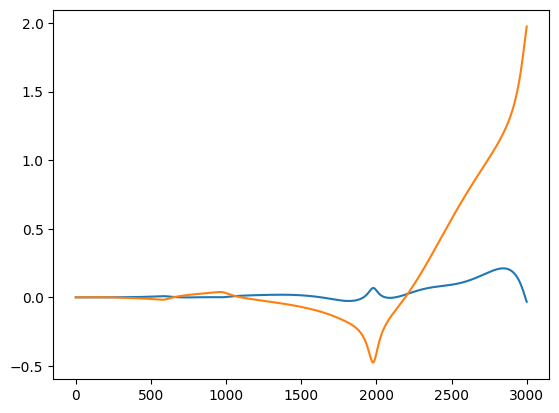

In [17]:
model,data,q3,w3,a3,xy3,t3 = run_model(my_controller2,ts=1e-3,integrator='RK4')
plt.plot(q3-q)

What does this mean?  Even with small position errors due to the wrong integration scheme or large time-steps, our computed torque starts to diverge from the torques required to acurately achieve a desired trajectory.  Thus, if we are doing inverse dynamics, we need to correct for those growing losses by adding a controller.